Author : Nelson Vithayathil Varghese

This is the Natural Language Processing (NLP) model implementation for the Text Classification with Transformer( BERt Encoder) and using the Kaggle Dataset SMS Spam Collection Dataset.

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df_data = pd.read_csv('spam.csv',encoding='ISO-8859-1')
df_data.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


Extract only the needed columns for the NLP task

In [3]:
df_data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [4]:
df_data = df_data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1)

In [5]:
df_data.head(3)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [6]:
# Rename the columns for better readability
df_data.rename(columns={'v1':'label','v2':'message'},inplace=True)

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


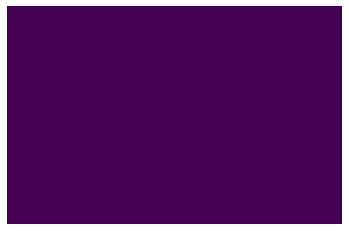

In [8]:
# Visually check for any missing / null values
sns.heatmap(df_data.isnull(),xticklabels=False,yticklabels=False,cbar = False,cmap='viridis')

In [9]:
df_data.shape
df_data.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [10]:
X = list(df_data['message'])
X[:5]

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'Ok lar... Joking wif u oni...',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'U dun say so early hor... U c already then say...',
 "Nah I don't think he goes to usf, he lives around here though"]

In [11]:
# Check how balanced the given dataset is
df_data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [12]:
# Above indicates the class imbalance
df_data.groupby(by='label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [13]:
df_bal_spam = df_data[df_data['label'] == 'spam']
df_bal_spam.shape

(747, 2)

In [14]:
# Perform the under-smapling to make the majority (ham) class to same as minority class
df_bal_ham = df_data[df_data['label'] == 'ham'].sample(df_bal_spam.shape[0])
df_bal_ham.shape

(747, 2)

In [15]:
# Concatenate both the dataframes
df_bal_dataset = pd.concat([df_bal_ham,df_bal_spam])
df_bal_dataset.shape

(1494, 2)

In [16]:
df_bal_dataset.rename(columns={'label':'Category'},inplace=True)
# Create a numeric column for the label
df_bal_dataset['label'] = df_bal_dataset['Category'].apply(lambda x: 1 if x == 'ham' else 0)
df_bal_dataset.head(5)

,Category,message,label
1581,ham,Hhahhaahahah rofl wtf nig was leonardo in your...,1
2512,ham,"Hiya , have u been paying money into my accoun...",1
483,ham,Thank you baby! I cant wait to taste the real ...,1
2657,ham,Dai &lt;#&gt; naal eruku.,1
2866,ham,"Mum, i've sent you many many messages since i ...",1


**Build the Model**

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_bal_dataset['message'],df_bal_dataset['label'], test_size=0.2, stratify=df_bal_dataset['label'])

import the preprocess and encoder urls from the TF Hub

https://tfhub.dev/google/collections/bert/1

https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4


In [18]:
preprocess_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
# bert_model_url ='https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4'

In [19]:
!pip install tensorflow_hub tensorflow_text

     |████████████████████████████████| 4.9 MB 5.7 MB/s 
     |████████████████████████████████| 462 kB 56.2 MB/s 


In [20]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

In [21]:
bert_preprocess_module = hub.KerasLayer(preprocess_url)
bert_encoder_module = hub.KerasLayer(bert_model_url)

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess_module(text_input)
outputs = bert_encoder_module(preprocessed_text)

# (['sequence_output', 'pooled_output', 'default', 'encoder_outputs'])

# Neural network layers for the binary classification - spam / ham 
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model -- 'pooled_output'
nn_model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [24]:
Metric = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=Metric)

In [25]:
nn_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
38/38 [==============================] - 24s 303ms/step - loss: 0.5721 - accuracy: 0.7531 - precision: 0.7635 - recall: 0.7341
Epoch 2/10
38/38 [==============================] - 12s 305ms/step - loss: 0.4622 - accuracy: 0.8469 - precision: 0.8609 - recall: 0.8278
Epoch 3/10
38/38 [==============================] - 12s 306ms/step - loss: 0.4079 - accuracy: 0.8603 - precision: 0.8671 - recall: 0.8512
Epoch 4/10
38/38 [==============================] - 12s 308ms/step - loss: 0.3662 - accuracy: 0.8921 - precision: 0.8995 - recall: 0.8829
Epoch 5/10
38/38 [==============================] - 12s 312ms/step - loss: 0.3457 - accuracy: 0.8828 - precision: 0.8921 - recall: 0.8712
Epoch 6/10
38/38 [==============================] - 12s 316ms/step - loss: 0.3191 - accuracy: 0.8954 - precision: 0.8948 - recall: 0.8963
Epoch 7/10
38/38 [==============================] - 12s 315ms/step - loss: 0.3018 - accuracy: 0.9038 - precision: 0.9185 - recall: 0.8863
Epoch 8/10
38/38 [================

In [26]:
nn_model.evaluate(X_test, y_test)

10/10 [==============================] - 4s 296ms/step - loss: 0.2342 - accuracy: 0.9398 - precision: 0.9712 - recall: 0.9060


[0.23419584333896637,
 0.9397993087768555,
 0.971222996711731,
 0.9060402512550354]

In [56]:
y_predictions = nn_model.predict(X_test)
# y_predictions
y_predictions = y_predictions.flatten()
y_predictions

array([0.22752465, 0.02307055, 0.9061807 , 0.21594569, 0.08052223,
       0.9722259 , 0.18660696, 0.318816  , 0.13696496, 0.22277015,
       0.96898156, 0.88944685, 0.84493434, 0.16778097, 0.9738598 ,
       0.03580685, 0.0482568 , 0.13678743, 0.87559617, 0.4389285 ,
       0.97523206, 0.91009444, 0.46983323, 0.97971904, 0.9469485 ,
       0.95196956, 0.2753541 , 0.07032512, 0.318816  , 0.10328744,
       0.18817945, 0.7791692 , 0.12645222, 0.04150305, 0.14605236,
       0.9427086 , 0.805502  , 0.07482487, 0.98650557, 0.7370352 ,
       0.19452977, 0.9327488 , 0.02771277, 0.94218314, 0.23109151,
       0.10522506, 0.8601867 , 0.04210356, 0.18023713, 0.09811029,
       0.8944323 , 0.92125285, 0.57159835, 0.01187988, 0.8197491 ,
       0.06700283, 0.10210437, 0.05169601, 0.34131745, 0.04647787,
       0.01752022, 0.9376735 , 0.27544135, 0.92882615, 0.87776196,
       0.1771758 , 0.10860072, 0.9722412 , 0.6945147 , 0.6292721 ,
       0.9707079 , 0.646963  , 0.2736478 , 0.91041595, 0.88109

In [37]:
# Convert it to a scale with 1 and 0
y_predictions = np.where(y_predictions > 0.5, 1, 0)
y_predictions

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0])

Plot confusion Matrix

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

cmatrix = confusion_matrix(y_test, y_predictions)
cmatrix 

array([[146,   4],
       [ 14, 135]])

Text(33.0, 0.5, 'GroundTruth')

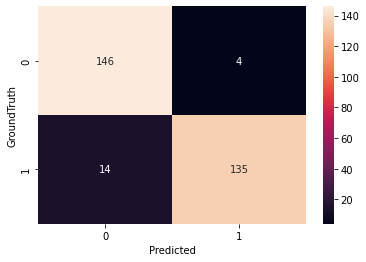

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cmatrix, annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('GroundTruth')

In [40]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       150
           1       0.97      0.91      0.94       149

    accuracy                           0.94       299
   macro avg       0.94      0.94      0.94       299
weighted avg       0.94      0.94      0.94       299



**Test the model with user inputs**

In [58]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
predictions = nn_model.predict(reviews)
# predictions = predictions.flatten(predictions)
predictions

array([[0.1987533 ],
       [0.14035122],
       [0.18860728],
       [0.8173109 ],
       [0.8967885 ]], dtype=float32)

In [61]:
predictions  = np.where( predictions > 0.5,1,0)
predictions
predictions = pd.DataFrame(data=predictions,columns=['Label'])
predictions['Label'].apply(lambda x : 'spam' if x == 0 else 'ham')

0    spam
1    spam
2    spam
3     ham
4     ham
Name: Label, dtype: object